# Outfit Compatibility Prediction - Zalando

For Zalando data, I have created train, validation and test data using negative samples from existing outfits. The samples are created by altering *only* one of the product. This still may not be the right way of generating negative samples. The data also have outfit style information that is unique to Zalando dataset. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import Counter
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import pickle

import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
print("NP:", np.__version__)

Populating the interactive namespace from numpy and matplotlib
TF: 2.2.0
NP: 1.19.5


In [3]:
base_dir = "/recsys_data/RecSys/Zalando_Outfit/female/Outfit_Data"
train_dir = base_dir
image_dir = "/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female"
embed_dir = "/recsys_data/RecSys/Zalando_Outfit/female/Outfit_Data/precomputed"
train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"

each line in the dataset has: label style item_1 item_2 item_3 ...

In [4]:
with open(os.path.join(train_dir, train_file), 'r') as fr:
    train_X, train_y = [], []
    for line in fr:
        elems = line.strip().split()
        train_y.append(elems[0])
        train_X.append(elems[1:])

with open(os.path.join(train_dir, valid_file), 'r') as fr:
    valid_X, valid_y = [], []
    for line in fr:
        elems = line.strip().split()
        valid_y.append(elems[0])
        valid_X.append(elems[1:])

with open(os.path.join(train_dir, test_file), 'r') as fr:
    test_X, test_y = [], []
    for line in fr:
        elems = line.strip().split()
        test_y.append(elems[0])
        test_X.append(elems[1:])

print(f"Total {len(train_X)}, {len(valid_X)}, {len(test_X)} examples in train, validation and test split, respectively")

Total 272541, 7479, 17427 examples in train, validation and test split, respectively


In [5]:
# item_dict converts a token in the dataset to the corresponding image (required for Polyvore data)
# Here, we create a dict to match the requirement
item_dict = {}
train_file = "zalando_female_outfit_data_18k_and_new_modified_format_train.json"
valid_file = "zalando_female_outfit_data_18k_and_new_modified_format_val.json"
test_file = "zalando_female_outfit_data_18k_and_new_modified_format_test.json"

train_json = os.path.join(base_dir, "Train", train_file)
train_data = json.load(open(train_json, 'r'))

item2cat = {}
cat2item = {}
seq_lens = []
count = 0
for outfit in train_data:
    items = outfit["item_ids"]
    categories = outfit["high_level_cats"]
    style = outfit["outfit_occasion"]
    for i,c in zip(items, categories):
        if c not in cat2item:
            cat2item[c] = []
        cat2item[c].append(i)
        item2cat[i] = {"category_id": c}
    seq_lens.append(len(items))
    count += 1
print(f"{count} training examples, average {np.mean(seq_lens):.2f} items, max {np.max(seq_lens)} item")

valid_json = os.path.join(base_dir, "Val", valid_file)
valid_data = json.load(open(valid_json, 'r'))

count = 0
seq_lens = []
for outfit in valid_data:
    items = outfit["item_ids"]
    categories = outfit["high_level_cats"]
    for i,c in zip(items, categories):
        cat2item[c].append(i)
        item2cat[i] = {"category_id": c}
    seq_lens.append(len(items))
    count += 1
print(f"{count} validation examples, average {np.mean(seq_lens):.2f} items, max {np.max(seq_lens)} items")

test_json = os.path.join(base_dir, "Test", test_file)
test_data = json.load(open(test_json, 'r'))

count = 0
seq_lens = []
for outfit in test_data:
    items = outfit["item_ids"]
    categories = outfit["high_level_cats"]
    for i,c in zip(items, categories):
        cat2item[c].append(i)
        item2cat[i] = {"category_id": c}
    seq_lens.append(len(items))
    count += 1
print(f"{count} test examples, average {np.mean(seq_lens):.2f} items, max {np.max(seq_lens)} item")

90847 training examples, average 3.89 items, max 8 item
2493 validation examples, average 4.12 items, max 7 items
5809 test examples, average 4.13 items, max 7 item


In [6]:
print(f"Total number of categories: {len(cat2item)}")

Total number of categories: 9


In [7]:
from build_model import build_single_transformer, build_multilevel_transformer
from build_model import build_set_transformer
from rnn import build_multilevel_rnn_unequal, build_fc_model, build_hybrid_model

In [8]:
model_type = "rnn" # "set-transformer", "rnn", "single-transformer"
include_text = False
use_graphsage = False
batch_size = 32
max_seq_len = 4
d_model_rnn = 256
image_data_type = "embedding"  # "original", "embedding", "both"
include_item_categories = True
image_encoder = "resnet50"  # "resnet50", "vgg16", "inception"

if use_graphsage:
    image_embedding_dim, image_embedding_file = (50, os.path.join(embed_dir, "graphsage_dict2_polyvore.pkl"))
#         image_embedding_dim, image_embedding_file = (256, os.path.join(embed_dir, "graphsage_dict2_polyvore_nondisjoint.pkl"))
else:
    image_embedding_dim, image_embedding_file = (1280, os.path.join(embed_dir, "effnet2_zalando.pkl"))
#         image_embedding_dim, image_embedding_file = (256, os.path.join(embed_dir, "triplet_polyvore_image.pkl"))
    
text_embedding_dim, text_embedding_file = (768, os.path.join(embed_dir, "bert_polyvore.pkl"))
# text_embedding_dim, text_embedding_file = (256, os.path.join(embed_dir, "triplet_polyvore_text.pkl"))

In [9]:
# from rnn import build_multilevel_rnn_unequal
# model_type = "hybrid"
if model_type == "fc":
    model = build_fc_model(max_seq_len, 
                           image_embedding_dim,
                         num_classes=2,
                         num_layers=2,
                         d_model=512,
                         rnn="bilstm",
                         final_activation="sigmoid",
                         include_text=include_text
                        )
elif model_type == "rnn":
    model = build_multilevel_rnn_unequal(max_seq_len, 
                                         num_classes=2,
                                         num_layers=2,
                                         d_model=d_model_rnn,
                                         rnn="bilstm",
                                         final_activation="sigmoid",
                                         include_text=include_text,
                                         image_embedding_dim=image_embedding_dim,
                                         text_feature_dim=text_embedding_dim,
                                         include_item_categories=include_item_categories,
                                         image_data_type=image_data_type,
                                         include_multihead_attention=False,
                                         image_encoder=image_encoder,
                                         num_categories=len(cat2item)+1,
                                         include_style=True,
                                         num_styles=7,
                                        )
elif model_type == "single-transformer":
    model = build_single_transformer(max_seq_len, 
                                     image_embedding_dim,
                                     num_layers=6,
                                     d_model=64,
                                     num_heads=16,
                                     dff=32,
                                     rate=0.0,
                                     include_text=include_text,
                                     include_item_categories=include_item_categories,
                                     num_categories=154,
                                     text_feature_dim=768,
                                     num_classes=2,
                                     lstm_dim=256,
                                     embedding_activation="linear",
                                     lstm_activation="linear",
                                     final_activation="sigmoid"
                                    )
elif model_type == "transformer":
    model = build_multilevel_transformer(max_seq_len, 
                                         image_embedding_dim,
                                         num_layers=3,
                                         d_model=64,
                                         num_heads=1,
                                         dff=32,
                                         rate=0.0,
                                         include_text=include_text,
                                         include_item_categories=include_item_categories,
                                         inp_dim2=768,
                                         num_classes=2,
                                         lstm_dim=256,
                                         embedding_activation="linear",
                                         lstm_activation="linear",
                                         final_activation="sigmoid"
                                        )
elif model_type == "set-transformer":
    model = build_set_transformer(max_seq_len, 
                                  image_embedding_dim, 
                                  num_layers=3,
                                  d_model=256,
                                  num_heads=2,
                                  dff=256,
                                  num_classes=2,
                                  lstm_dim=256,
                                  include_text=include_text,
                                  inp_dim2=768,
                                  embedding_activation="relu",
                                  lstm_activation="relu",
                                  final_activation="sigmoid"
                                 )
elif model_type == "hybrid":
    model = build_hybrid_model(max_seq_len, 
                               image_embedding_dim,
                               rnn="bilstm",
                               num_layers=2,
                               d_model=512,
                               num_heads=2,
                               dff=32,
                               rate=0.0,
                               include_text=include_text,
                               text_feature_dim=text_embedding_dim,
                               num_classes=2,
                               embedding_activation="tanh",
                               lstm_activation="linear",
                               final_activation="sigmoid",
                               include_item_categories=include_item_categories,
                               num_categories=154,
                              )

model.summary()

Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 1280)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_Sum (TensorFlowOpLa [(None, 4)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 4)]          0           tf_op_layer_Sum[0][0]            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
________________________________________________________________________________________________

In [10]:
from data_process import ZalandoDataGen

train_gen = ZalandoDataGen(train_X, train_y, 
                          item2cat, 
                          image_dir=image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          number_items_in_batch=150,
                          variable_length_input=True,
                          text_embedding_dim=text_embedding_dim,
                          include_item_categories=include_item_categories,
                          image_data=image_data_type,
                         )
valid_gen = ZalandoDataGen(valid_X, valid_y, 
                          item2cat, 
                          image_dir=image_dir, 
                          batch_size=batch_size,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          number_items_in_batch=150,
                          variable_length_input=True,
                          text_embedding_dim=text_embedding_dim,
                          include_item_categories=include_item_categories,
                          image_data=image_data_type,
                         )
print(len(train_gen), len(valid_gen))

8517 234


In [11]:
for ii in range(4):
    inps, targs = train_gen[ii]
    print([x.shape for x in inps], targs.shape)
#     print(inps.shape, targs.shape)

[(32, 4, 1280), (32, 4), (32,)] (32,)
[(32, 4, 1280), (32, 4), (32,)] (32,)
[(32, 4, 1280), (32, 4), (32,)] (32,)
[(32, 4, 1280), (32, 4), (32,)] (32,)


In [12]:
inps[2]

array([2, 0, 1, 2, 0, 2, 3, 0, 1, 4, 4, 4, 3, 1, 6, 1, 1, 3, 2, 0, 1, 3,
       2, 5, 2, 2, 2, 3, 5, 0, 0, 5])

In [13]:
from focal_loss import BinaryFocalLoss

learning_rate = 1.0e-04
epochs = 50
patience = 5
num_train = len(train_X)
checkpoint_filepath = base_dir + '/zalando_checkpoint'

opt = keras.optimizers.Adam(learning_rate=learning_rate)
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, name='binary_crossentropy')
# loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=False, name='binary_focal_crossentropy')
loss = BinaryFocalLoss(gamma=2)

model.compile(loss=loss, optimizer=opt, metrics=[tf.keras.metrics.AUC()])  # "accuracy"
callback = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=patience,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=True,
                    )

# wandb_callback = WandbCallback(
#                         monitor="val_loss",
#                         verbose=0,
#                         save_model=(False), 
#                         mode="auto")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-07)

tic = time.time()
# run = wandb.init(reinit=True)
if 'history' in locals():
    history_prev = history
history = model.fit(train_gen, 
                    epochs=epochs, 
                    batch_size=batch_size,
#                     steps_per_epoch=math.ceil(num_train/batch_size),
                    validation_data=valid_gen,
                    validation_batch_size=32,
                    validation_freq=1,
                    callbacks=[callback, reduce_lr],
                    verbose=1)
# run.finish()
time.time() - tic

Epoch 1/50
8517/8517 [==============================] - 437s 51ms/step - loss: 0.1606 - auc: 0.5388 - val_loss: 0.1593 - val_auc: 0.5313 - lr: 1.0000e-04
Epoch 2/50
8517/8517 [==============================] - 424s 50ms/step - loss: 0.1558 - auc: 0.5722 - val_loss: 0.1593 - val_auc: 0.5567 - lr: 1.0000e-04
Epoch 3/50
8517/8517 [==============================] - 426s 50ms/step - loss: 0.1536 - auc: 0.5928 - val_loss: 0.1599 - val_auc: 0.5595 - lr: 1.0000e-04
Epoch 4/50
8517/8517 [==============================] - 419s 49ms/step - loss: 0.1508 - auc: 0.6123 - val_loss: 0.1606 - val_auc: 0.5687 - lr: 5.0000e-05
Epoch 5/50
8517/8517 [==============================] - 392s 46ms/step - loss: 0.1493 - auc: 0.6228 - val_loss: 0.1637 - val_auc: 0.5740 - lr: 5.0000e-05
Epoch 6/50
8517/8517 [==============================] - 396s 46ms/step - loss: 0.1474 - auc: 0.6344 - val_loss: 0.1663 - val_auc: 0.5783 - lr: 2.5000e-05
Epoch 7/50
8517/8517 [==============================] - 394s 46ms/step - los

2913.7548706531525

In [17]:
history = model.fit(train_gen, 
                    epochs=1, 
                    batch_size=batch_size,
                    verbose=1)


8517/8517 [==============================] - 396s 47ms/step - loss: 0.1391 - auc: 0.6785


In [15]:
print("Done")

Done


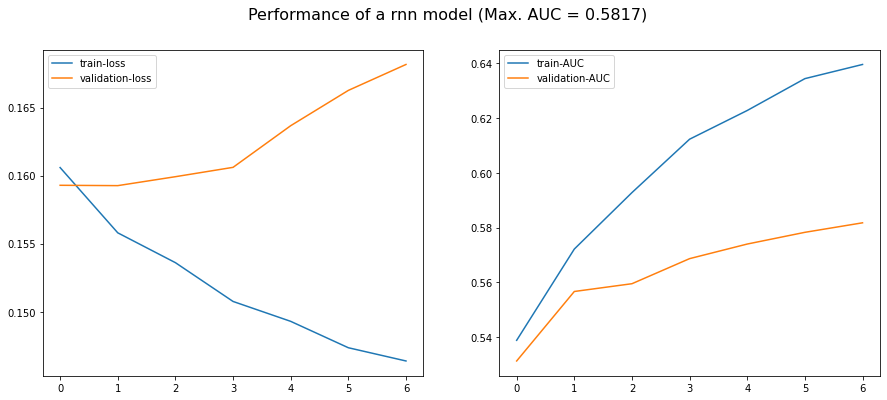

In [16]:
auc_str = "auc"
f, axs = plt.subplots(1,2,figsize=(15,6))
max_val_auc = max(history.history[f'val_{auc_str}'])
f.suptitle(f'Performance of a {model_type} model (Max. AUC = {max_val_auc:.4})', fontsize=16)
plt.subplot(121)
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history[auc_str], label='train-AUC')
plt.plot(history.history[f'val_{auc_str}'], label='validation-AUC')
plt.legend()

In [18]:
model_path = f"compatibility_zalando_{model_type}_model_{max_seq_len}_only_image"
model.save(model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: compatibility_zalando_rnn_model_4_only_image/assets


## Load Model and Test

In [1]:
import os
import json
from collections import Counter
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import pickle

import sys
sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt
from focal_loss import BinaryFocalLoss

print("TF:", tf.__version__)
print("NP:", np.__version__)

model = tf.keras.models.load_model('compatibility_zalando_rnn_model_8_only_image')
model.summary()

Populating the interactive namespace from numpy and matplotlib
TF: 2.2.0
NP: 1.19.5
Model: "rnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 8, 1280)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_Sum_4 (TensorFlowOp (None, 8)            0           input_13[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_NotEqual_4 (TensorF (None, 8)            0           tf_op_layer_Sum_4[0][0]          
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 8)]          0                                            
____________

In [19]:
from data_process import ZalandoDataGen

train_X = [["0", "SIF21C000-Q11@13.jpg", "CA115O00F-Q11@11.jpg", "EV451H0M7-Q11@13.jpg"]]
train_y = 0
train_gen = ZalandoDataGen(train_X, train_y, 
                          item2cat, 
                          image_dir=image_dir, 
                          batch_size=1,
                          max_len=max_seq_len,
                          only_image=not include_text,
                          image_embedding_dim=image_embedding_dim,
                          image_embedding_file=image_embedding_file,
                          text_embedding_file=text_embedding_file,
                          number_items_in_batch=150,
                          variable_length_input=True,
                          text_embedding_dim=text_embedding_dim,
                          include_item_categories=include_item_categories,
                          image_data=image_data_type,
                         )
inps, targs = train_gen[0]
pred = model(inps)
pred.numpy()

array([[0.3166604]], dtype=float32)

## Image Embedding

In [4]:
import glob
efficient_net_dict = {}

eff2_model = tf.keras.models.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
                    effnetv2_model.get_model("efficientnetv2-b0", include_top=False),
                ]
            )

count = 0
for image_path in tqdm(glob.glob(image_dir+"/*.*")):
    item_id = image_path.split('/')[-1].split('.')[0]
    image = tf.keras.preprocessing.image.load_img(image_path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    image_arr = tf.image.resize(image_arr, (224, 224)).numpy()
    image_arr /= 255.0
    image_embed = tf.squeeze(eff2_model(tf.expand_dims(image_arr, 0)))
    efficient_net_dict[item_id] = image_embed
    count += 1
    
print(f"Generated embeddings for {count} images")

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.
100%|██████████| 51985/51985 [1:41:11<00:00,  8.56it/s]

Generated embeddings for 51985 images


In [5]:
with open(os.path.join(embed_dir, "effnet2_zalando.pkl"), "wb") as output_file:
    pickle.dump(efficient_net_dict, output_file)

In [19]:
item_id

'DOG81A000-A11@12'

In [20]:
glob.glob(image_dir+"/V1021C1YY-K11@5*.*")

['/recsys_data/RecSys/Zalando_Outfit/resized_packshot_images_female/V1021C1YY-K11@5.2.jpg']